In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sympy as sym

import pycollocation
import pyam

In [3]:
pyam.__version__

'0.1.2a0'

## Defining inputs

Need to define some heterogenous factors of production...

In [4]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': 1e0, 'mu1': 0.0, 'sigma1': 1.0}

# to avoid the discontinuity at the lower bound need to add eps
eps = 1e-3
skill_bounds = [skill_params['loc1'] + eps, 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 1e0, 'mu2': 0.0, 'sigma2': 1.0}

# to avoid the discontinuity at the lower bound need to add eps
productivity_bounds = [productivity_params['loc2'] + eps, 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )

Note that we are shifting the distributions of worker skill and firm productivity to the right by 1.0 in order to try and avoid issues with having workers (firms) with near zero skill (productivity).

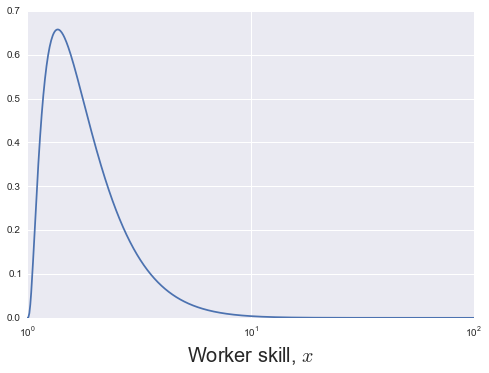

In [5]:
xs = np.linspace(workers.lower, workers.upper, 1e4)
plt.plot(xs, workers.evaluate_pdf(xs))
plt.xscale('log')
plt.xlabel('Worker skill, $x$', fontsize=20)
plt.show()

## Defining a production process

Next need to define some production process...

In [6]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [7]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.0 }

## Define a boundary value problem

In [8]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=sym.limit(F, sigma_B, 1),
                                          F_params=F_params)

## Pick some collocation solver

In [9]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [10]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 75, 'theta': 75},
                                                    exp=0.5)

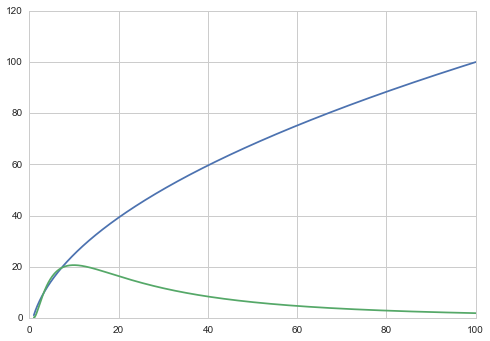

In [11]:
# quickly plot the initial conditions
sn.set_style("whitegrid")
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [12]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [13]:
solver.result.success

True

## Plot some results

In [14]:
viz = pyam.Visualizer(solver)

In [39]:
10**1e-3

1.0023052380778996

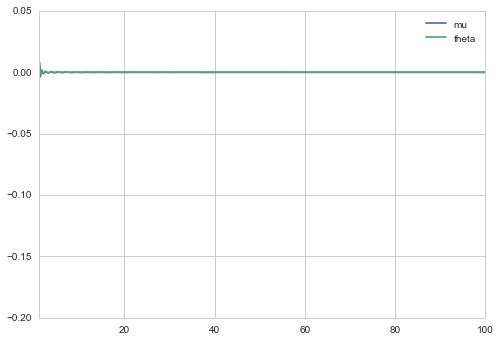

In [40]:
viz.interpolation_knots = np.logspace(1e-3, 2, 1000)
viz.residuals.plot()
plt.show()

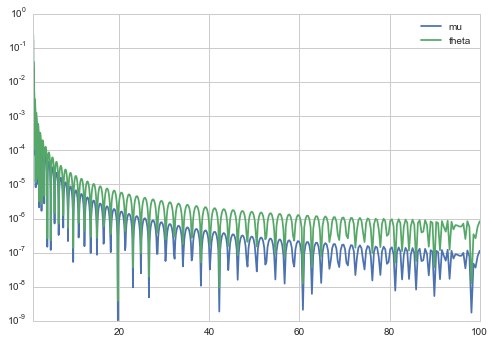

In [41]:
viz.normalized_residuals[['mu', 'theta']].plot(logy=True)
plt.show()

In [53]:
viz.solution.tail()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
98.173889,291.084421,16.961730,8.480865,145.542210,0.750285,0.043720,0.375143,0.011234,2.179130,0.126980,1.089565,16.961730,145.542210,99.776518,8.580623
98.627267,291.334180,17.001270,8.500635,145.667090,0.745227,0.043489,0.372614,0.011163,2.181971,0.127332,1.090985,17.001270,145.667090,99.833795,8.568012
99.082738,291.580210,17.040780,8.520390,145.790105,0.740186,0.043259,0.370093,0.011092,2.184806,0.127686,1.092403,17.040780,145.790105,99.890131,8.555366
99.540312,291.822403,17.080263,8.540132,145.911202,0.735161,0.043029,0.367580,0.011022,2.187635,0.128041,1.093817,17.080263,145.911202,99.945526,8.542679
100.000000,292.060903,17.119717,8.559858,146.030452,0.730152,0.042799,0.365076,0.010952,2.190457,0.128398,1.095228,17.119717,146.030452,100.000000,8.529957


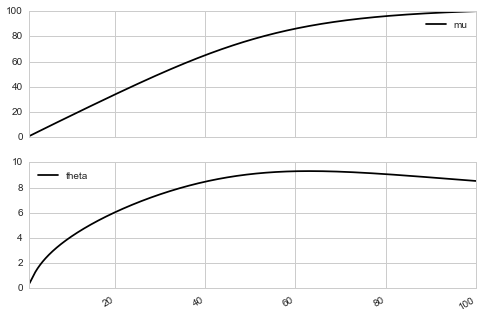

In [43]:
viz.solution[['mu', 'theta']].plot(subplots=True)
plt.show()

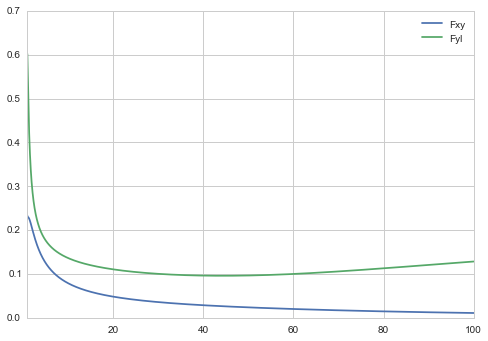

In [44]:
viz.solution[['Fxy', 'Fyl']].plot()
plt.show()

## Plot factor payments
Note the `factor_payment_1` is wages and `factor_payment_2` is profits...

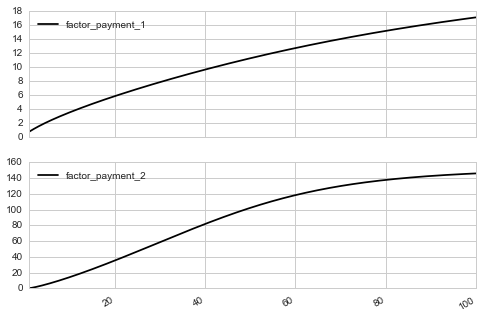

In [45]:
viz.solution[['factor_payment_1', 'factor_payment_2']].plot(subplots=True)
plt.show()

## Plot the density for firm size

As you can see, the theta function is hump-shaped. Nothing special, but when calculating the pdf some arrangements have to be done for this: sort the thetas preserving the order (so we can relate them to their xs) and then use carefully the right x for calculating the pdf.

The principle of Philipp's trick is:

$pdf_x(x_i)$ can be interpreted as *number of workers with ability x*. $\theta_i$ is the size of the firms that employs workers of kind $x_i$. As all firms that match with workers type $x_i$ choose the same firm size, $pdf_x(x_i)/\theta_i$ is the number of firms of size $\theta_i$.

Say there are 100 workers with ability $x_i$, and their associated firm size $\theta_i$ is 2. Then there are $100/2 = 50$ $ \theta_i$ firms

In [46]:
# philipp's trick in 3 lines...
sorted_data = viz.solution.sort('theta', ascending=True, inplace=False)
theta_pdf = workers.evaluate_pdf(sorted_data.index.values) / sorted_data.theta
theta_cdf = theta_pdf.cumsum() / theta_pdf.sum()

#...survival function is also useful
theta_sf = 1 - theta_cdf

In [47]:
# these might also be useful later...
def emprical_cdf(series):
    sq = series.value_counts()
    cdf = sq.sort_index().cumsum() * (1.0 / series.count())
    return cdf

def empirical_sf(series):
    return 1 - emprical_cdf(series)

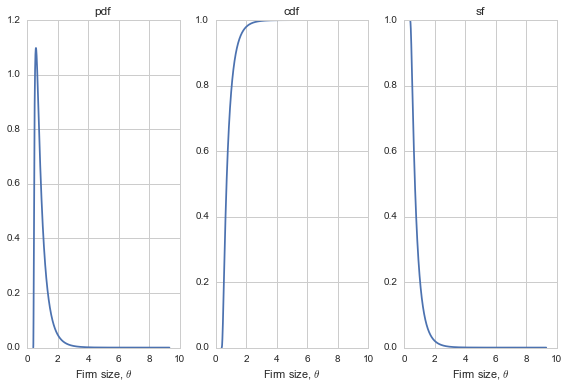

In [48]:
fig, axes = plt.subplots(1, 3)
axes[0].plot(sorted_data.theta, theta_pdf)
axes[0].set_xlabel(r'Firm size, $\theta$')
axes[0].set_title(r'pdf')

axes[1].plot(sorted_data.theta, theta_cdf)
axes[1].set_title(r'cdf')
axes[1].set_xlabel(r'Firm size, $\theta$')

axes[2].plot(sorted_data.theta, theta_sf)
axes[2].set_title(r'sf')
axes[2].set_xlabel(r'Firm size, $\theta$')

plt.tight_layout()
plt.show()

Note: the long (almost invisible) tail of the Cdfs is due to the extreme value of 100 at the end.

## Distributions of factor payments

Is the code below correct? If so, I could add these functions as methods to the `pyam.Vizualizer` class.

In [58]:
# these will not work for variable=theta...but I think they should work for the others
def compute_pdf(viz, variable):
    """Compute the pdf for a variable given a vizualizer."""
    sorted_data = viz.solution.sort(variable, ascending=True, inplace=False)
    pdf = viz.solver.problem.input1.evaluate_pdf(sorted_data.index.values)
    return pdf

def compute_cdf(pdf):
    """Compute the cdf given a pdf."""
    cdf = pdf.cumsum() / pdf.sum()
    return cdf

def compute_sf(cdf):
    """Compute the sf given the cdf."""
    sf = 1 - cdf
    return sf

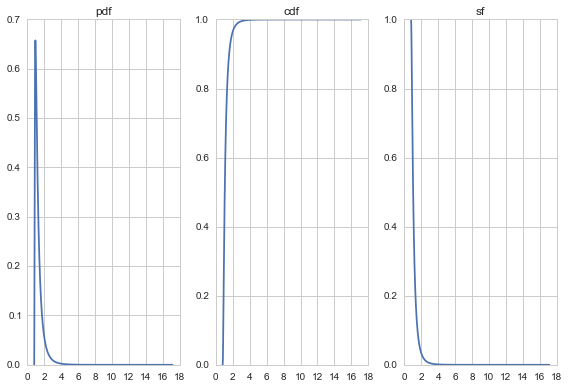

In [62]:
w_pdf = compute_pdf(viz, "factor_payment_1")
w_cdf = compute_cdf(w_pdf)
w_sf = compute_sf(w_cdf)

fig, axes = plt.subplots(1, 3)
w = viz.solution.factor_payment_1.sort(inplace=False)
axes[0].plot(w, w_pdf)
axes[0].set_title(r'pdf')

axes[1].plot(w, w_cdf)
axes[1].set_title(r'cdf')

axes[2].plot(w, w_sf)
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()

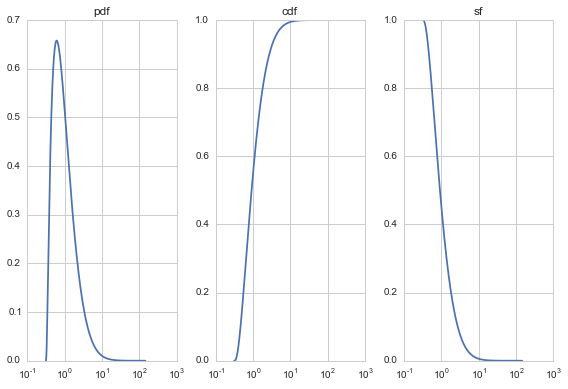

In [66]:
pi_pdf = compute_pdf(viz, "factor_payment_2")
pi_cdf = compute_cdf(pi_pdf)
pi_sf = compute_sf(pi_cdf)

fig, axes = plt.subplots(1, 3)
pi = viz.solution.factor_payment_2.sort(inplace=False)
axes[0].plot(pi, pi_pdf)
axes[0].set_xscale('log')
axes[0].set_title(r'pdf')

axes[1].plot(pi, pi_cdf)
axes[1].set_xscale('log')
axes[1].set_title(r'cdf')

axes[2].plot(pi, pi_sf)
axes[2].set_xscale('log')
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()